<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!pip install 'shimmy>=2.0'
!pip install pandas_market_calendars
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
✨🍰✨ Everything looks OK!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-4w5gjbyr
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-4w5gjbyr
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d25d902a6de54931a329adc38a2663e8f576adc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-0qax8xkn/elegantrl_5c88f20bf1444375aa3


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [ ]:
TRAIN_START_DATE = '2016-02-02'
TRAIN_END_DATE = '2023-12-31'
TRADE_START_DATE = '2024-01-02'
TRADE_END_DATE = '2025-04-11'

In [5]:
df = pd.read_csv('data.csv')

In [6]:
print(df.isnull().sum())

date      0
close     0
high      0
low       0
open      0
volume    0
tic       0
day       0
dtype: int64


In [7]:
df.shape

(24243, 8)

In [8]:
day_values_per_tic = df.groupby('tic')['day'].apply(lambda x: sorted(x.unique())).reset_index()
day_values_per_tic.columns = ['tic', 'unique_days']

# Display
print(day_values_per_tic)

      tic            unique_days
0     agg        [0, 1, 2, 3, 4]
1     bil        [0, 1, 2, 3, 4]
2  btcusd  [0, 1, 2, 3, 4, 5, 6]
3     gld        [0, 1, 2, 3, 4]
4     spy        [0, 1, 2, 3, 4]
5      vb        [0, 1, 2, 3, 4]
6     vnq        [0, 1, 2, 3, 4]
7      vo        [0, 1, 2, 3, 4]
8     vwo        [0, 1, 2, 3, 4]


In [9]:
# Match 5-day and 7-day tickers using apply
tics_5day = day_values_per_tic[day_values_per_tic['unique_days'].apply(lambda x: x == list(range(5)))]['tic']
tics_7day = day_values_per_tic[day_values_per_tic['unique_days'].apply(lambda x: x == list(range(7)))]['tic']

# Filter the original df
df_5day_full = df[df['tic'].isin(tics_5day)]
df_7day_full = df[df['tic'].isin(tics_7day)]

# Results
print("5-day tickers:", tics_5day.tolist())
print("7-day tickers:", tics_7day.tolist())
print("5-day df shape:", df_5day_full.shape)
print("7-day df shape:", df_7day_full.shape)

5-day tickers: ['agg', 'bil', 'gld', 'spy', 'vb', 'vnq', 'vo', 'vwo']
7-day tickers: ['btcusd']
5-day df shape: (20520, 8)
7-day df shape: (3723, 8)


In [10]:
df.shape

(24243, 8)

In [11]:
df.head()

,date,close,high,low,open,volume,tic,day
0,2015-02-01,228.99,233.790,210.00,218.67,7220.0,btcusd,6
1,2015-02-02,112.20,112.230,112.00,112.06,2792120.0,agg,0
2,2015-02-02,91.46,91.480,91.46,91.48,3557487.0,bil,0
3,2015-02-02,237.83,240.100,220.89,228.39,7421.0,btcusd,0
4,2015-02-02,122.42,123.155,121.82,121.84,8885189.0,gld,0


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df_5day_full = fe.preprocess_data(df_5day_full)
df_7day_full = fe.preprocess_data(df_7day_full)

Successfully added technical indicators
Successfully added technical indicators


In [13]:
df_5day_full.shape

(20520, 16)

In [14]:
df_7day_full.shape

(3723, 16)

In [15]:
df = pd.concat([df_5day_full, df_7day_full], ignore_index=False)
df.index = range(len(df))  # Assign new sequential index


In [16]:
df.shape

(24243, 16)

In [17]:
df.head(50)

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2015-02-02,112.20,112.2300,112.0000,112.06,2792120.0,agg,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,112.200000,112.200000
1,2015-02-02,91.46,91.4800,91.4600,91.48,3557487.0,bil,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,91.460000,91.460000
2,2015-02-02,122.42,123.1550,121.8200,121.84,8885189.0,gld,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,122.420000,122.420000
3,2015-02-02,201.92,202.0300,197.8600,200.05,163106969.0,spy,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,201.920000,201.920000
4,2015-02-02,115.12,115.2100,112.8500,114.38,549866.0,vb,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,115.120000,115.120000
5,2015-02-02,86.32,86.6900,84.6851,86.53,7523640.0,vnq,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,86.320000,86.320000
6,2015-02-02,122.30,122.3899,119.9400,121.66,823489.0,vo,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,122.300000,122.300000
7,2015-02-02,40.65,40.7600,40.2800,40.40,15944366.0,vwo,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.000000,40.650000,40.650000
8,2015-02-03,111.77,112.1000,111.7600,112.10,1815375.0,agg,1,-0.009647,112.593112,111.376888,0.000000,-66.666667,100.000000,111.985000,111.985000
9,2015-02-03,91.48,91.4800,91.4600,91.46,266084.0,bil,1,0.000449,91.498284,91.441716,100.000000,66.666667,100.000000,91.470000,91.470000


In [18]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Remove rows where the date appears only once
df = df[df.groupby('date')['date'].transform('count') > 1]

# Sort by date
df = df.sort_values('date').reset_index(drop=True)


In [19]:
df.shape

(23085, 16)

In [20]:
df.head(20)

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2015-02-02,112.20,112.2300,112.0000,112.06,2792120.0,agg,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,112.200000,112.200000
1,2015-02-02,40.65,40.7600,40.2800,40.40,15944366.0,vwo,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,40.650000,40.650000
2,2015-02-02,122.30,122.3899,119.9400,121.66,823489.0,vo,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,122.300000,122.300000
3,2015-02-02,86.32,86.6900,84.6851,86.53,7523640.0,vnq,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,86.320000,86.320000
4,2015-02-02,237.83,240.1000,220.8900,228.39,7421.0,btcusd,0,0.198333,245.911648,220.908352,100.000000,66.666667,100.0,233.410000,233.410000
5,2015-02-02,201.92,202.0300,197.8600,200.05,163106969.0,spy,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,201.920000,201.920000
6,2015-02-02,122.42,123.1550,121.8200,121.84,8885189.0,gld,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,122.420000,122.420000
7,2015-02-02,91.46,91.4800,91.4600,91.48,3557487.0,bil,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,91.460000,91.460000
8,2015-02-02,115.12,115.2100,112.8500,114.38,549866.0,vb,0,0.000000,112.593112,111.376888,0.000000,-66.666667,100.0,115.120000,115.120000
9,2015-02-03,111.77,112.1000,111.7600,112.10,1815375.0,agg,1,-0.009647,112.593112,111.376888,0.000000,-66.666667,100.0,111.985000,111.985000


## Add covariance matrix as states

In [21]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2015-02-02,112.20,112.2300,112.0000,112.06,2792120.0,agg,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,112.20,112.20
1,2015-02-02,40.65,40.7600,40.2800,40.40,15944366.0,vwo,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,40.65,40.65
2,2015-02-02,122.30,122.3899,119.9400,121.66,823489.0,vo,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,122.30,122.30
3,2015-02-02,86.32,86.6900,84.6851,86.53,7523640.0,vnq,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,86.32,86.32
4,2015-02-02,237.83,240.1000,220.8900,228.39,7421.0,btcusd,0,0.198333,245.911648,220.908352,100.0,66.666667,100.0,233.41,233.41


In [22]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)


In [23]:
df.shape

(20817, 18)

In [24]:
df.head(10)

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2016-02-02,109.32,109.380,109.1301,109.23,4835115.0,agg,1,0.207871,109.414436,108.155564,56.401620,128.048919,18.311124,108.540000,108.509083,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
1,2016-02-02,91.34,91.360,91.3400,91.34,1627284.0,bil,1,-0.003626,91.386806,91.327194,46.986934,-124.094203,12.399460,91.360333,91.364333,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
2,2016-02-02,372.93,374.410,371.1700,371.33,6817.0,btcusd,1,-12.397434,422.125588,352.168412,45.804685,-84.272928,40.704445,405.695000,419.803333,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
3,2016-02-02,108.09,108.180,107.3500,107.92,6656018.0,gld,1,1.135824,108.620100,102.477820,56.790972,143.671556,35.269843,104.479307,103.650320,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
4,2016-02-02,190.16,191.970,189.5400,191.96,182564890.0,spy,1,-2.744645,199.106331,183.296129,43.397377,-51.889822,20.952982,195.478153,201.393583,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
5,2016-02-02,99.93,101.300,99.5600,101.23,806243.0,vb,1,-2.286971,107.259181,95.234819,39.656457,-58.511357,32.436105,104.496667,109.190167,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
6,2016-02-02,76.42,77.000,75.9900,76.75,6405965.0,vnq,1,-0.590040,80.000387,73.562613,46.993766,-52.042083,19.794014,77.738333,78.155167,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
7,2016-02-02,108.76,110.390,108.3705,110.39,1044394.0,vo,1,-2.324530,116.708953,104.273047,39.842589,-62.826827,28.141177,113.705333,118.021333,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
8,2016-02-02,29.61,30.074,29.5250,30.01,29716675.0,vwo,1,-0.602581,31.511900,28.106100,40.930317,-50.822375,20.542572,30.827333,32.391667,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
9,2016-02-03,109.31,109.640,109.2000,109.26,3700282.0,agg,2,0.219987,109.409405,108.289595,56.284904,134.384090,26.433157,108.571000,108.518083,"[[5.680538253214838e-06, 1.0046908129070853e-0...",tic agg bil btcusd ...


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


## Training data split: 2009-01-01 to 2020-07-01

In [25]:
train = data_split(df, TRAIN_START_DATE, TRAIN_END_DATE)
# trade = data_split(df, TRADE_START_DATE, TRADE_END_DATE)

In [26]:
train.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2016-02-02,109.32,109.38,109.1301,109.23,4835115.0,agg,1,0.207871,109.414436,108.155564,56.401620,128.048919,18.311124,108.540000,108.509083,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
0,2016-02-02,91.34,91.36,91.3400,91.34,1627284.0,bil,1,-0.003626,91.386806,91.327194,46.986934,-124.094203,12.399460,91.360333,91.364333,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
0,2016-02-02,372.93,374.41,371.1700,371.33,6817.0,btcusd,1,-12.397434,422.125588,352.168412,45.804685,-84.272928,40.704445,405.695000,419.803333,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
0,2016-02-02,108.09,108.18,107.3500,107.92,6656018.0,gld,1,1.135824,108.620100,102.477820,56.790972,143.671556,35.269843,104.479307,103.650320,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
0,2016-02-02,190.16,191.97,189.5400,191.96,182564890.0,spy,1,-2.744645,199.106331,183.296129,43.397377,-51.889822,20.952982,195.478153,201.393583,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...


## Environment for Portfolio Allocation


In [27]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]


    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()

            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")

            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions)
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]
        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output


    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [28]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 9, State Space: 9


In [29]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [30]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [31]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [32]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [33]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 227       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -12.8     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 5.95e+07  |
|    reward             | 1849145.2 |
|    std                | 0.999     |
|    value_loss         | 3.54e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 230       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -12.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

In [34]:
trained_a2c.save('/content/trained_models/trained_a2c.zip')

### Model 2: **PPO**


In [35]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [36]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=80000)

begin_total_asset:1000000
end_total_asset:3339953.4777343967
Sharpe:  1.0699361182985687
----------------------------------
| time/              |           |
|    fps             | 363       |
|    iterations      | 1         |
|    time_elapsed    | 5         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1115476.2 |
----------------------------------
begin_total_asset:1000000
end_total_asset:3436889.9502175623
Sharpe:  1.0813623747792618
---------------------------------------
| time/                   |           |
|    fps                  | 364       |
|    iterations           | 2         |
|    time_elapsed         | 11        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -12.8     |
|    explained_variance   | 1.19e-07  |
|    learning_rate        |

In [37]:
trained_ppo.save('/content/trained_models/trained_ppo.zip')

### Model 3: **DDPG**


In [38]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [39]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:3176788.403897253
Sharpe:  1.0663116028661987
begin_total_asset:1000000
end_total_asset:3205606.66476353
Sharpe:  1.0738164858479031
begin_total_asset:1000000
end_total_asset:3205606.66476353
Sharpe:  1.0738164858479031
begin_total_asset:1000000
end_total_asset:3205606.66476353
Sharpe:  1.0738164858479031
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 30        |
|    time_elapsed    | 260       |
|    total_timesteps | 7968      |
| train/             |           |
|    actor_loss      | -7.36e+07 |
|    critic_loss     | 1.29e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 7867      |
|    reward          | 3205606.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:3205606.66476353
Sharpe:  1.0738164858479031
begin_total_asset:1000000
end_total_asset:3205606.66476353
Sharpe:  1.0738164858479031
begin_total_asset:1000

In [40]:
trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

### Model 4: **SAC**


In [41]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [42]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:2427203.917667749
Sharpe:  0.9526455471258991
begin_total_asset:1000000
end_total_asset:2333214.6956811254
Sharpe:  0.9200031168226575
begin_total_asset:1000000
end_total_asset:2333214.6956811254
Sharpe:  0.9200031168226575
begin_total_asset:1000000
end_total_asset:2333214.6956811254
Sharpe:  0.9200031168226575
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 29        |
|    time_elapsed    | 267       |
|    total_timesteps | 7968      |
| train/             |           |
|    actor_loss      | -5.79e+07 |
|    critic_loss     | 8.38e+11  |
|    ent_coef        | 1.09      |
|    ent_coef_loss   | -7.04     |
|    learning_rate   | 0.0003    |
|    n_updates       | 7867      |
|    reward          | 2333214.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2333214.6956811254
Sharpe:  0.9200031168226575
begin_total_asset:1000000
end_t

In [43]:
trained_sac.save('/content/trained_models/trained_sac.zip')

### Model 5: **TD3**


In [44]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [45]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=30000)

begin_total_asset:1000000
end_total_asset:2637438.2194515998
Sharpe:  0.9376241747404737
begin_total_asset:1000000
end_total_asset:2541411.63140989
Sharpe:  0.9064089191357926
begin_total_asset:1000000
end_total_asset:2541411.63140989
Sharpe:  0.9064089191357926
begin_total_asset:1000000
end_total_asset:2541411.63140989
Sharpe:  0.9064089191357926
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 34        |
|    time_elapsed    | 233       |
|    total_timesteps | 7968      |
| train/             |           |
|    actor_loss      | -3.39e+07 |
|    critic_loss     | 4.42e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 7867      |
|    reward          | 2541411.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2541411.63140989
Sharpe:  0.9064089191357926
begin_total_asset:1000000
end_total_asset:2541411.63140989
Sharpe:  0.9064089191357926
begin_total_asset:100

In [ ]:
trained_td3.save('/content/trained_models/trained_td3.zip')

### Model 6: **DRLEnsemble**


In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [ ]:
trade = data_split(df, TRADE_START_DATE, TRADE_END_DATE)
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [ ]:
trade.shape

In [77]:
df_daily_return_1, df_actions_1 = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)
df_daily_return_2, df_actions_2 = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)
df_daily_return_3, df_actions_3 = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)
df_daily_return_4, df_actions_4 = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)
df_daily_return_5, df_actions_5 = DRLAgent.DRL_prediction(model=trained_td3,
                        environment = e_trade_gym)

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:1184345.945765014
Sharpe:  0.9492695355186077
hit end!


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:1156761.6249157246
Sharpe:  0.9304520394123291
hit end!


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:1148348.6251069878
Sharpe:  0.881382143579046
hit end!


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:1143089.3419027003
Sharpe:  0.9702546618271248
hit end!


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:1096083.0005219523
Sharpe:  0.6203250741293926
hit end!


In [78]:
df_daily_return_1.head()

,date,daily_return
0,2024-01-02,0.000000
1,2024-01-03,-0.017029
2,2024-01-04,0.004894
3,2024-01-05,-0.000064
4,2024-01-08,0.017663


In [79]:
df_daily_return_1.to_csv('df_daily_return_1.csv')
df_daily_return_2.to_csv('df_daily_return_2.csv')
df_daily_return_3.to_csv('df_daily_return_3.csv')
df_daily_return_4.to_csv('df_daily_return_4.csv')
df_daily_return_5.to_csv('df_daily_return_5.csv')

In [81]:
df_actions_1.head()
df_actions_2.head()
df_actions_3.head()
df_actions_4.head()
df_actions_5.head()

,agg,bil,btcusd,gld,spy,vb,vnq,vo,vwo
date,,,,,,,,,
2024-01-02,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2024-01-03,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251,0.063000
2024-01-04,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251,0.063000
2024-01-05,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251,0.063000
2024-01-08,0.063000,0.171251,0.063000,0.063000,0.171251,0.171251,0.063000,0.171251,0.063000


In [82]:
df_actions_1.to_csv('df_actions_1.csv')
df_actions_2.to_csv('df_actions_2.csv')
df_actions_3.to_csv('df_actions_3.csv')
df_actions_4.to_csv('df_actions_4.csv')
df_actions_5.to_csv('df_actions_5.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [85]:
return_dfs = [df_daily_return_1, df_daily_return_2, df_daily_return_3, df_daily_return_4, df_daily_return_5]
agent_names = ['A2C', 'DDPG', 'PPO', 'SAC', 'TD3']

for i, df_return in enumerate(return_dfs):
    strat = convert_daily_return_to_pyfolio_ts(df_return)
    stats = timeseries.perf_stats(strat)
    print(f"\nPerformance Stats for {agent_names[i]}:\n")
    print(stats)



Performance Stats for A2C:

Annual return          0.142521
Cumulative returns     0.184346
Annual volatility      0.152583
Sharpe ratio           0.949270
Calmar ratio           1.117097
Stability              0.831765
Max drawdown          -0.127582
Omega ratio            1.174078
Sortino ratio          1.456085
Skew                   0.424457
Kurtosis               3.772263
Tail ratio             1.027726
Daily value at risk   -0.018649
dtype: float64

Performance Stats for DDPG:

Annual return          0.121514
Cumulative returns     0.156762
Annual volatility      0.132681
Sharpe ratio           0.930452
Calmar ratio           1.042173
Stability              0.856915
Max drawdown          -0.116596
Omega ratio            1.175110
Sortino ratio          1.395552
Skew                   0.509572
Kurtosis               6.926433
Tail ratio             1.047395
Daily value at risk   -0.016226
dtype: float64

Performance Stats for PPO:

Annual return          0.115085
Cumulative returns

In [56]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (320, 8)
Annual return          0.039023
Cumulative returns     0.049811
Annual volatility      0.152133
Sharpe ratio           0.327907
Calmar ratio           0.238390
Stability              0.688739
Max drawdown          -0.163692
Omega ratio            1.065541
Sortino ratio          0.476284
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.870880
Daily value at risk   -0.018969
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (320, 8)



/usr/local/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.252%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Start date,2024-01-02
End date,2025-04-10
Total months,15
,Backtest
Annual return,14.252%
Cumulative returns,18.435%
Annual volatility,15.258%
Sharpe ratio,0.95
Calmar ratio,1.12
Stability,0.83
Max drawdown,-12.758%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.76,2024-12-16,2025-04-08,NaT,NaN
1,5.86,2024-07-22,2024-08-05,2024-08-23,25
2,5.83,2024-03-28,2024-05-01,2024-05-20,38
3,4.46,2024-05-20,2024-07-05,2024-07-16,42
4,4.34,2024-08-23,2024-09-06,2024-09-18,19


/usr/local/lib/python3.11/dist-packages/matplotlib/dates.py:449: UserWarning:

no explicit representation of timezones available for np.datetime64

/usr/local/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Stress Events,mean,min,max
Covid,0.06%,-3.68%,5.52%


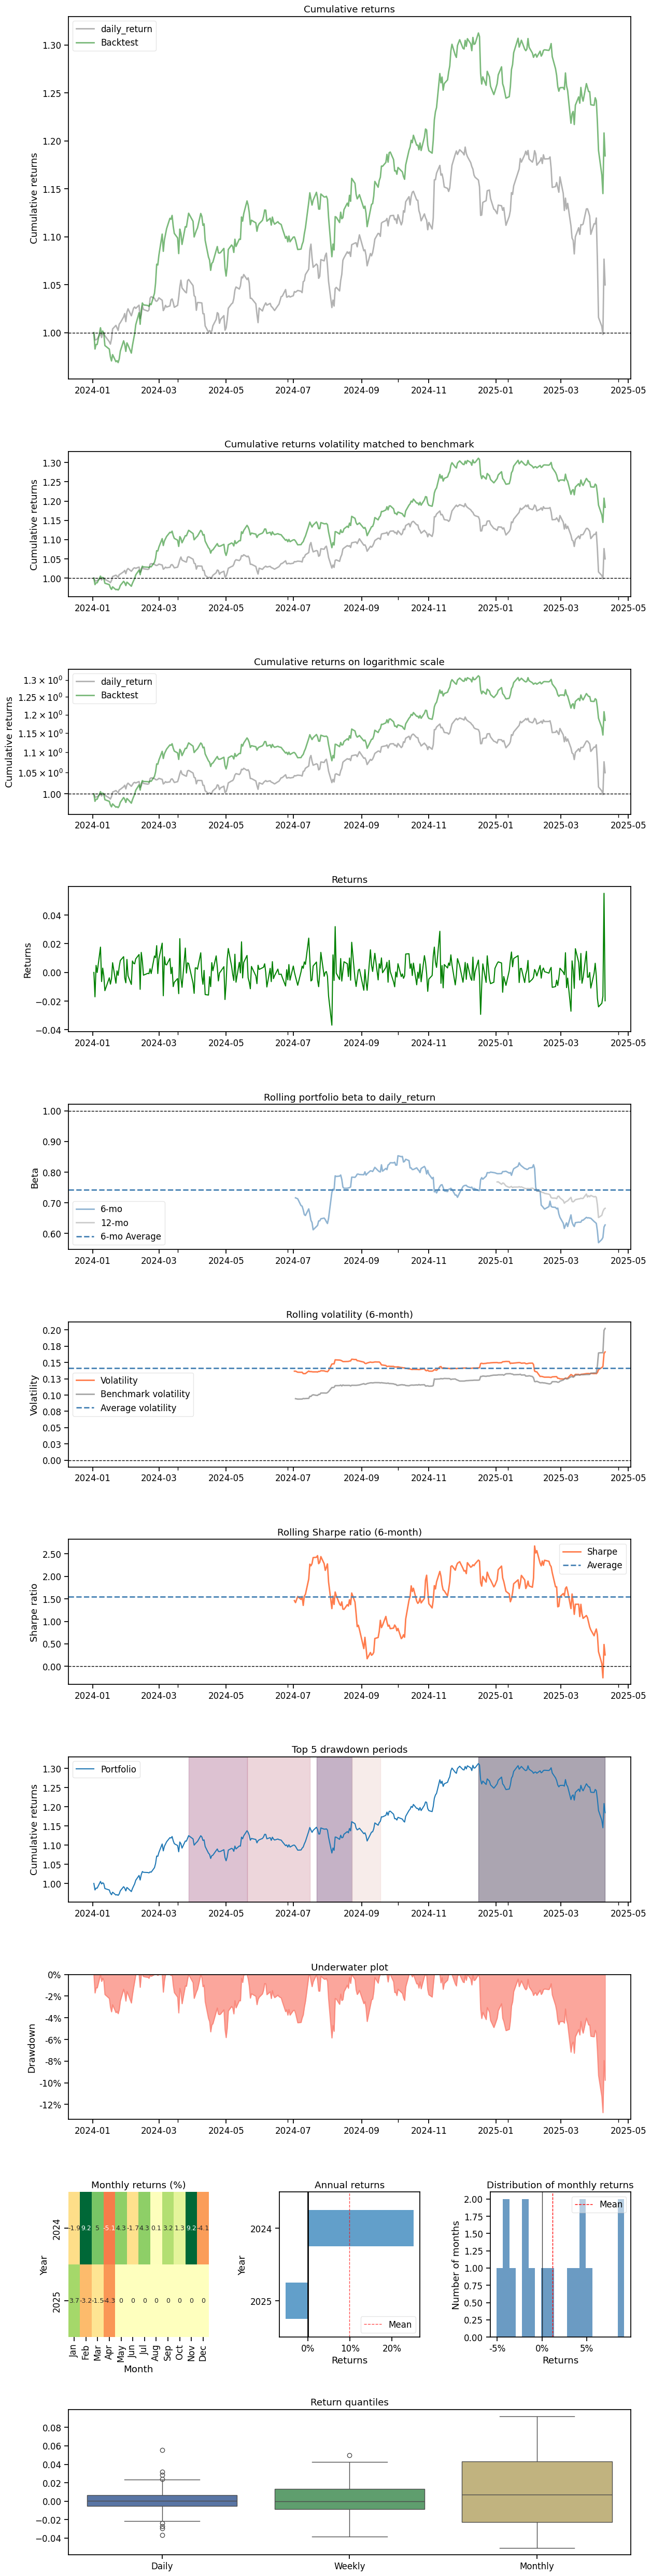

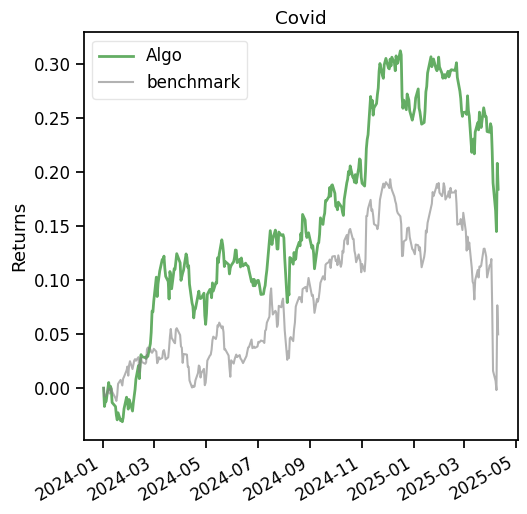

In [92]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return_1.loc[0,'date'], end=TRADE_END_DATE
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Min-Variance Portfolio Allocation

In [58]:
%pip install PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [60]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [61]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2016-02-02,109.32,109.38,109.1301,109.23,4835115.0,agg,1,0.207871,109.414436,108.155564,56.401620,128.048919,18.311124,108.540000,108.509083,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
1,2016-02-02,91.34,91.36,91.3400,91.34,1627284.0,bil,1,-0.003626,91.386806,91.327194,46.986934,-124.094203,12.399460,91.360333,91.364333,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
2,2016-02-02,372.93,374.41,371.1700,371.33,6817.0,btcusd,1,-12.397434,422.125588,352.168412,45.804685,-84.272928,40.704445,405.695000,419.803333,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
3,2016-02-02,108.09,108.18,107.3500,107.92,6656018.0,gld,1,1.135824,108.620100,102.477820,56.790972,143.671556,35.269843,104.479307,103.650320,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...
4,2016-02-02,190.16,191.97,189.5400,191.96,182564890.0,spy,1,-2.744645,199.106331,183.296129,43.397377,-51.889822,20.952982,195.478153,201.393583,"[[5.736252007431306e-06, 6.71030337777799e-09,...",tic agg bil btcusd ...


In [63]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.15))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()

    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)

portfolio=portfolio.T
portfolio.columns = ['account_value']

In [64]:
portfolio.head()

,account_value
2024-01-02,1000000
2024-01-03,991726.299581
2024-01-04,991399.73261
2024-01-05,991842.209717
2024-01-08,998396.892456


In [93]:
a2c_cumpod =(df_daily_return_1.daily_return+1).cumprod()-1
ddpg_cumpod =(df_daily_return_2.daily_return+1).cumprod()-1
ppo_cumpod =(df_daily_return_3.daily_return+1).cumprod()-1
sac_cumpod =(df_daily_return_4.daily_return+1).cumprod()-1
td3_cumpod =(df_daily_return_5.daily_return+1).cumprod()-1

In [73]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

<ipython-input-73-2a1c4bec35f1>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1


In [ ]:
dji_cumpod =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [67]:
%pip install plotly

In [68]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [69]:
time_ind = pd.Series(df_daily_return.date)

In [98]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')
trace1_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG (Portfolio Allocation)')
trace2_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod, mode = 'lines', name = 'PPO (Portfolio Allocation)')
trace3_portfolio = go.Scatter(x = time_ind, y = sac_cumpod, mode = 'lines', name = 'SAC (Portfolio Allocation)')
trace4_portfolio = go.Scatter(x = time_ind, y = td3_cumpod, mode = 'lines', name = 'TD3 (Portfolio Allocation)')
# trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace5_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
# trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
# trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
# trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [99]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)

fig.add_trace(trace3_portfolio)

fig.add_trace(trace4_portfolio)

fig.add_trace(trace5_portfolio)


fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2

    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date',
       'tick0': time_ind[0],
        'tickmode': 'linear',
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()